In [53]:
import numpy as np
import pandas as pd
import math
import os, sys
import matplotlib.pyplot as plt
import skimage.io
from random import shuffle
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from tensorflow import keras
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.regularizers import l1, l2
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import keras
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, GlobalAveragePooling2D, Attention, Convolution2D, MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from keras.metrics import SparseCategoricalAccuracy
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [2]:
np.random.seed(2023)

In [3]:
DIR = "/Users/andrewcosta/Desktop/Milan/AMS/project/aptos2019-blindness-detection/"
TRAIN_DIR = DIR + "train.csv"
TEST_DIR = DIR + "test.csv"
TRAIN_IMG_PATH = DIR + "train_images/"
TEST_IMG_PATH = DIR + "test_images/"

In [4]:
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DIR)

# Add extension to id_code
train_df['id_code'] = train_df['id_code'] + ".png"
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())
print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DIR)

# Add extension to id_code
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())

Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


In [5]:
train_df.shape

(3662, 2)

In [6]:
test_df.shape

(1928, 1)

In [7]:
def pad_width(image, new_shape, is_rgb=True):
    pad_dff = new_shape - image.shape[0], new_shape - image.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    
    if is_rgb:
        pad_width = ((t,b), (l,r), (0,0))
    else:
        pad_width = ((t,b), (l,r))
    
    return pad_width

def preprocess(path, desired_size=224):
    image = Image.open(path)
    image = image.resize((desired_size,)*2, resample=Image.LANCZOS)
    
    return image

In [8]:
train_df.shape[0]

3662

In [9]:
N = train_df.shape[0]
X_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    X_train[i, :, :, :] = preprocess(
        f"/Users/andrewcosta/Desktop/Milan/AMS/project/aptos2019-blindness-detection/train_images/{image_id}"
    )

100%|███████████████████████████████████████| 3662/3662 [15:34<00:00,  3.92it/s]


In [10]:
N = test_df.shape[0]
X_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    X_test[i, :, :, :] = preprocess(
        f"/Users/andrewcosta/Desktop/Milan/AMS/project/aptos2019-blindness-detection/test_images/{image_id}"
    )

100%|███████████████████████████████████████| 1928/1928 [02:57<00:00, 10.86it/s]


In [11]:
y_train = pd.get_dummies(train_df['diagnosis']).values

In [12]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

In [14]:
BATCH_SIZE = 32


def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(X_train, y_train, batch_size=BATCH_SIZE, seed=2019)

In [67]:
callback = EarlyStopping(monitor='loss', patience=10)

def base_model(loss, optimizer, metrics):
    model = Sequential()
    model.add(Conv2D(kernel_size=(5, 5), filters=8, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), padding='same'))
    model.add(MaxPooling2D(pool_size=(6, 6)))
    model.add(Flatten())
    model.add(Dense(units=5, activation='sigmoid'))


    model.compile(optimizer=optimizer,
                  loss = loss,
                  metrics = metrics
    )
    print(model.summary)
    return model

In [64]:
base_model = base_model(loss = 'binary_crossentropy' , 
                        optimizer = Adam(learning_rate=0.00005), 
                        metrics =['accuracy'] 
                       )

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x169fab970>>


In [65]:
base_history = base_model.fit_generator(data_generator,
                                        steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
                                        epochs=15,
                                        validation_data=(X_val, y_val),
                                        callbacks=[callback]
                                       )

/var/folders/0r/s7nt6zcj6m7fmc369tc6jzch0000gn/T/ipykernel_14526/3862225693.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  base_history = base_model.fit_generator(data_generator,


Epoch 1/15
97/97 [==============================] - 102s 1s/step - loss: 12.8087 - accuracy: 0.9168 - val_loss: 3.1721 - val_accuracy: 1.0000
Epoch 2/15
97/97 [==============================] - 96s 983ms/step - loss: 7.3408 - accuracy: 0.9708 - val_loss: 2.1876 - val_accuracy: 1.0000
Epoch 3/15
97/97 [==============================] - 96s 985ms/step - loss: 4.3497 - accuracy: 0.9457 - val_loss: 1.3809 - val_accuracy: 0.9982
Epoch 4/15
97/97 [==============================] - 99s 1s/step - loss: 2.5223 - accuracy: 0.9139 - val_loss: 1.0010 - val_accuracy: 0.9527
Epoch 5/15
97/97 [==============================] - 91s 929ms/step - loss: 1.7614 - accuracy: 0.8798 - val_loss: 0.8226 - val_accuracy: 0.9473
Epoch 6/15
97/97 [==============================] - 99s 1s/step - loss: 1.4892 - accuracy: 0.9023 - val_loss: 0.7084 - val_accuracy: 0.9836
Epoch 7/15
97/97 [==============================] - 101s 1s/step - loss: 1.3093 - accuracy: 0.9187 - val_loss: 0.6878 - val_accuracy: 0.9927
Epoch 8/

<AxesSubplot: >

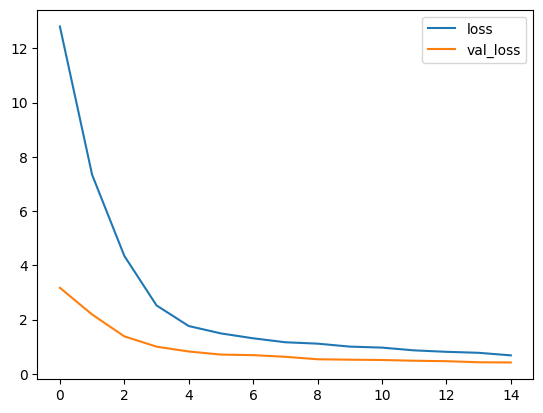

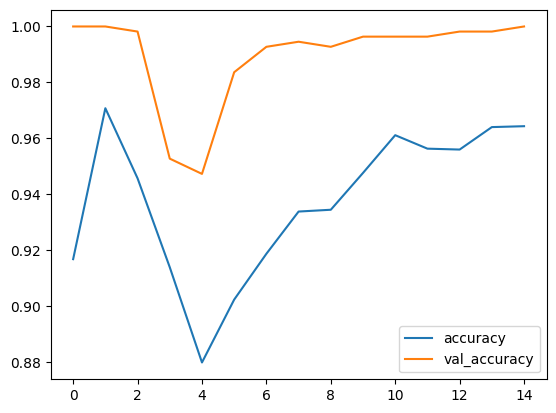

In [66]:
history_df = pd.DataFrame(base_history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [68]:
kl_divergence_function = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(244., dtype=tf.float32)

bcnn_model_one = tf.keras.Sequential([
    
    tfp.layers.Convolution2DFlipout(8, kernel_size=(5,5), strides=(1,1), 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1a", 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.MaxPool2D(pool_size=(6,6), padding="same"),
    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(5, kernel_divergence_fn=kl_divergence_function),
])

In [73]:
bcnn_model_one.compile(loss='binary_crossentropy',
                        optimizer= Adam(learning_rate=0.00005),
              metrics=['accuracy'])

In [ ]:
history = bcnn_model_one.fit_generator(data_generator,
                                        steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
                                        epochs=15,
                                        validation_data=(X_val, y_val),
                                        callbacks=[callback])

/var/folders/0r/s7nt6zcj6m7fmc369tc6jzch0000gn/T/ipykernel_14526/954553059.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = bcnn_model_one.fit_generator(data_generator,
/usr/local/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/15
97/97 [==============================] - 174s 2s/step - loss: 1312.5083 - accuracy: 0.5572 - val_loss: 1310.6215 - val_accuracy: 0.6982
Epoch 2/15
97/97 [==============================] - 164s 2s/step - loss: 1309.7306 - accuracy: 0.6922 - val_loss: 1308.0535 - val_accuracy: 0.7836
Epoch 3/15
97/97 [==============================] - 155s 2s/step - loss: 1307.1992 - accuracy: 0.7844 - val_loss: 1305.5063 - val_accuracy: 0.9073
Epoch 4/15
97/97 [==============================] - 164s 2s/step - loss: 1304.6826 - accuracy: 0.8862 - val_loss: 1303.0581 - val_accuracy: 0.9236
Epoch 5/15
97/97 [==============================] - 178s 2s/step - loss: 1302.5985 - accuracy: 0.9229 - val_loss: 1301.1477 - val_accuracy: 0.9636
Epoch 6/15
97/97 [==============================] - 178s 2s/step - loss: 1300.5145 - accuracy: 0.9238 - val_loss: 1299.0748 - val_accuracy: 0.9636
Epoch 7/15
97/97 [==============================] - 164s 2s/step - loss: 1298.3497 - accuracy: 0.9383 - val_loss: 1296

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss]].plot()
history_df[['accuracy', 'val_accuracy]].plot()